**Project for Lecture 4: Yield Curve Spread Trades**  
MFGMTMFE 400 Investments - Cohort 1  
Group 9: Mingqi Sui, Diana Zhang, Tong Liu, Valentina Cortés, Edoardo Pettinato

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load the uploaded Federal bond data file
file_path = r'C:\Users\76721\Desktop\UCLA\Fall-2024\Investments\Lecture 4\feds200628.csv'
bonds = pd.read_csv(file_path, skiprows=9)


# Adjusting to use the 'Date' column and re-running the previous setup steps
bonds.rename(columns={'Date': 'Dates'}, inplace=True)
bonds['Dates'] = pd.to_datetime(bonds['Dates'], errors='coerce')

# Select only the columns related to zero-coupon bonds and filter complete rows (no missing data)
zero_bonds = bonds[['Dates', 'SVENY02', 'SVENY10', 'BETA0', 'BETA1', 'BETA2', 'BETA3', 'TAU1', 'TAU2']].dropna()

# Convert the dataframe to a time series format, restricting dates between 1983-12-30 and 2017-06-30
zero_bonds.set_index('Dates', inplace=True)
spot_rates = zero_bonds['1983-12-30':'2024-09-30']

# Display initial data to verify structure
spot_rates.head()


,SVENY02,SVENY10,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
Dates,,,,,,,,
1983-12-30,10.5502,11.6444,11.838493,-2.805414,-618.567862,619.829427,1.626814,1.627871
1984-01-03,10.5670,11.6924,11.917554,-2.907937,-618.582602,619.815210,1.627005,1.627888
1984-01-04,10.5266,11.6307,11.855745,-2.850503,-618.604871,619.793054,1.627213,1.628060
1984-01-05,10.5003,11.6289,11.825377,-2.796791,-618.627824,619.770315,1.626904,1.628236
1984-01-06,10.4820,11.6118,11.840267,-2.898498,-618.603966,619.794160,1.627244,1.628163


In [3]:
# Resample spot_rates to weekly frequency (end of week) using mean values to approximate weekly spot rates
weekly_spot = spot_rates.resample('W-FRI').last().dropna()

# Rename columns to match the required names for 2-year and 10-year bond yields
weekly_spot.rename(columns={"SVENY02": "yield.2yr.on", "SVENY10": "yield.10yr.on"}, inplace=True)

# Define the zero-coupon bond price function with continuous compounding
def zero_price(face_value, yield_pct, maturity):
    return face_value * np.exp(-maturity * yield_pct / 100)

# Initialize a new DataFrame for the portfolio
portfolio = weekly_spot[['yield.2yr.on', 'yield.10yr.on']].copy()

# Calculate and add on-the-run prices for 2-year and 10-year bonds
portfolio['price.2yr.on'] = zero_price(100, portfolio['yield.2yr.on'], 2)
portfolio['price.10yr.on'] = zero_price(100, portfolio['yield.10yr.on'], 10)

# Display initial rows of the portfolio for verification
portfolio.head()

,yield.2yr.on,yield.10yr.on,price.2yr.on,price.10yr.on
Dates,,,,
1983-12-30,10.5502,11.6444,80.977083,31.209739
1984-01-06,10.4820,11.6118,81.087611,31.311649
1984-01-13,10.3243,11.4332,81.343765,31.875898
1984-01-20,10.3269,11.4478,81.339535,31.829393
1984-01-27,10.3017,11.4479,81.380541,31.829075


In [4]:
# Calculate DV01 for on-the-run 2-year and 10-year bonds
portfolio['DV01.2yr'] = 2 * 100 * np.exp(-2 * portfolio['yield.2yr.on'] / 100) / 10000 
portfolio['DV01.10yr'] = 10 * 100 * np.exp(-10 * portfolio['yield.10yr.on'] / 100) / 10000

# Calculate the shorting ratio 'X' needed to hedge 10-year bond positions with 2-year bonds
portfolio['X'] = portfolio['DV01.10yr'] / portfolio['DV01.2yr']

# Display initial rows of the portfolio to verify calculations
portfolio.head()


,yield.2yr.on,yield.10yr.on,price.2yr.on,price.10yr.on,DV01.2yr,DV01.10yr,X
Dates,,,,,,,
1983-12-30,10.5502,11.6444,80.977083,31.209739,0.016195,0.031210,1.927072
1984-01-06,10.4820,11.6118,81.087611,31.311649,0.016218,0.031312,1.930730
1984-01-13,10.3243,11.4332,81.343765,31.875898,0.016269,0.031876,1.959333
1984-01-20,10.3269,11.4478,81.339535,31.829393,0.016268,0.031829,1.956576
1984-01-27,10.3017,11.4479,81.380541,31.829075,0.016276,0.031829,1.955570


In [5]:
# Define function to estimate the yield of off-the-run bonds using Nelson-Siegel parameters
def estimated_yield(params, t):
    t1 = t / params['TAU1']
    t2 = t / params['TAU2']
    yield_estimate = (
        params['BETA0'] + 
        params['BETA1'] * (1 - np.exp(-t1)) / t1 + 
        params['BETA2'] * ((1 - np.exp(-t1)) / t1 - np.exp(-t1)) + 
        params['BETA3'] * ((1 - np.exp(-t2)) / t2 - np.exp(-t2))
    )
    return yield_estimate

# Calculate the off-the-run yield for 2-year and 10-year bonds
t2 = 1 + 358 / 365  # Adjusted maturity for 2-year bond in years
t10 = 9 + 358 / 365  # Adjusted maturity for 10-year bond in years

# Apply the estimated yield function row-wise using TAU and BETA parameters
portfolio['yield.2yr.off'] = weekly_spot.apply(lambda row: estimated_yield(row, t2), axis=1)
portfolio['yield.10yr.off'] = weekly_spot.apply(lambda row: estimated_yield(row, t10), axis=1)

# Display initial rows of the portfolio to verify the calculated off-the-run yields
portfolio.head()


,yield.2yr.on,yield.10yr.on,price.2yr.on,price.10yr.on,DV01.2yr,DV01.10yr,X,yield.2yr.off,yield.10yr.off
Dates,,,,,,,,,
1983-12-30,10.5502,11.6444,80.977083,31.209739,0.016195,0.031210,1.927072,10.540997,11.643953
1984-01-06,10.4820,11.6118,81.087611,31.311649,0.016218,0.031312,1.930730,10.472679,11.611268
1984-01-13,10.3243,11.4332,81.343765,31.875898,0.016269,0.031876,1.959333,10.315305,11.432673
1984-01-20,10.3269,11.4478,81.339535,31.829393,0.016268,0.031829,1.956576,10.317527,11.447455
1984-01-27,10.3017,11.4479,81.380541,31.829075,0.016276,0.031829,1.955570,10.292506,11.447565


In [6]:
# Calculate the closing prices (off-the-run) for 2-year and 10-year bonds using the zero_price function
portfolio['price.2yr.off'] = zero_price(100, portfolio['yield.2yr.off'], t2)
portfolio['price.10yr.off'] = zero_price(100, portfolio['yield.10yr.off'], t10)

# Calculate the weekly price differences for holding the bonds
portfolio['price_difference.10yr'] = portfolio['price.10yr.off'].shift(-1) - portfolio['price.10yr.on']
portfolio['price_difference.2yr'] = portfolio['price.2yr.off'].shift(-1) - portfolio['price.2yr.on']

# Display initial rows to verify calculations
portfolio[['price.2yr.off','price.10yr.off','price_difference.10yr','price_difference.2yr']].head()


,price.2yr.off,price.10yr.off,price_difference.10yr,price_difference.2yr
Dates,,,,
1983-12-30,81.155885,31.280909,0.173382,0.288701
1984-01-06,81.265783,31.383121,0.635901,0.431898
1984-01-13,81.519509,31.947549,0.024552,0.172156
1984-01-20,81.515921,31.900450,0.070705,0.216796
1984-01-27,81.556332,31.900098,0.134969,0.247191


In [7]:
# Calculate the risk-free rate for cash (7-day T-bill yield)
t_bill_days = 7 / 365  # 7-day maturity in years
portfolio['risk_free'] = weekly_spot.apply(lambda row: estimated_yield(row, t_bill_days), axis=1)

# Set leverage ratio for a 10% capital requirement
leverage_ratio_10pct = 1 / 0.1

# Display initial rows of portfolio to verify the risk-free rate calculation
portfolio[['risk_free']].head()


,risk_free
Dates,
1983-12-30,9.054593
1984-01-06,8.963713
1984-01-13,8.871909
1984-01-20,8.970577
1984-01-27,9.027196


In [8]:
# Define the flattener trade function
def flattener_trade(portfolio, leverage_ratio):
    # Initialize columns in the portfolio for position tracking and capital calculations
    portfolio = portfolio.copy()  # Ensure we're not modifying the original DataFrame
    portfolio['cost'] = portfolio['price.10yr.on'] + portfolio['X'] * portfolio['price.2yr.on']
    portfolio['position_revenue'] = 0.0
    portfolio['interest_on_cash'] = 0.0
    portfolio['position'] = 0.0
    portfolio['capital'] = 0.0
    portfolio['capital'].iloc[0] = 1_000_000  # Start with an initial capital of $1,000,000

    # Loop to update position and calculate capital each week
    for i in range(len(portfolio) - 1):
        # Update position based on leverage ratio and current cost
        portfolio.at[portfolio.index[i], 'position'] = portfolio['capital'].iloc[i] * leverage_ratio / portfolio['cost'].iloc[i]
        num_long = portfolio['position'].iloc[i]
        num_short = num_long * portfolio['X'].iloc[i]

        # Calculate cash on hand after adjusting long and short positions
        cash_on_hand = (portfolio['capital'].iloc[i] +
                        num_short * portfolio['price.2yr.on'].iloc[i] -
                        num_long * portfolio['price.10yr.on'].iloc[i])

        # Revenue generated by closing out positions
        portfolio.at[portfolio.index[i], 'position_revenue'] = (
            num_long * portfolio['price_difference.10yr'].iloc[i] -
            num_short * portfolio['price_difference.2yr'].iloc[i]
        )

        # Interest earned on cash
        portfolio.at[portfolio.index[i], 'interest_on_cash'] = (
            cash_on_hand * (np.exp(portfolio['risk_free'].iloc[i] / 100 * 7 / 365) - 1)
        )

        # Calculate capital for the next week
        portfolio.at[portfolio.index[i + 1], 'capital'] = (
            portfolio['capital'].iloc[i] +
            portfolio['position_revenue'].iloc[i] +
            portfolio['interest_on_cash'].iloc[i]
        )

    # Calculate cumulative return of the flattener trading strategy
    portfolio['cumulative_return'] = portfolio['capital'] / 1_000_000 - 1

    return portfolio

# Run the flattener trade simulation for a 10% capital requirement
total_return_10pct = flattener_trade(portfolio, leverage_ratio_10pct)

# Display the cumulative return and first few rows of the final results
total_return_10pct[['cumulative_return']].head()


C:\Users\76721\AppData\Local\Temp\ipykernel_9464\144451647.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  portfolio['capital'].iloc[0] = 1_000_000  # Start with an initial capital of $1,000,000


,cumulative_return
Dates,
1983-12-30,0.000000
1984-01-06,-0.007126
1984-01-13,-0.004492
1984-01-20,-0.007775
1984-01-27,-0.013041


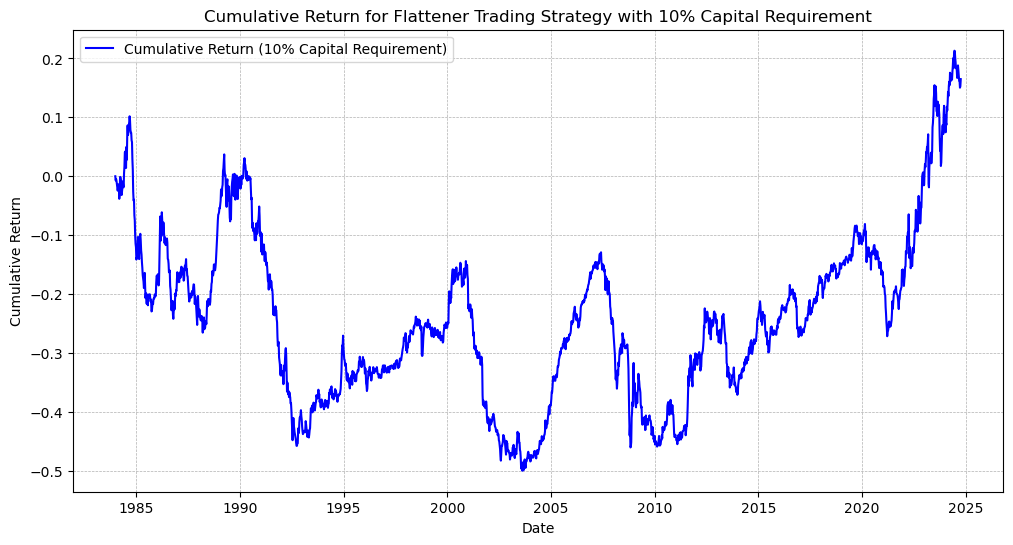

In [9]:
# Plot the cumulative return over time
plt.figure(figsize=(12, 6))
plt.plot(total_return_10pct.index, total_return_10pct['cumulative_return'], label="Cumulative Return (10% Capital Requirement)", color="blue")
plt.title("Cumulative Return for Flattener Trading Strategy with 10% Capital Requirement")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()


1. **2000–2007: Positive Returns During a Flattening Yield Curve**  
* Context: This period includes the dot-com bubble burst (early 2000s recession) and a recovery phase.
* Federal Reserve Actions: To combat the economic slowdown and stimulate growth, the Federal Reserve lowered interest rates starting in 2001, cutting the federal funds rate from around 6.5% to 1% by mid-2003.
* Yield Curve Behavior: Lower short-term rates led to a decrease in the yield on short-term bonds, while long-term bond yields declined more gradually, reflecting both lower inflation expectations and a flight to safety as investors preferred longer-term bonds for stability. This caused the yield curve to flatten.
* Impact on Flattener Strategy: The flattening yield curve led to a narrower spread between 10-year and 2-year yields, benefiting the flattener strategy. The long position in 10-year bonds gained as their prices increased with declining yields, while the short position in 2-year bonds did not generate significant losses due to their relatively stable yields.  
2. **2008 Financial Crisis: Losses Due to Yield Curve Steepening**
* Context: The 2008 global financial crisis brought severe economic contraction and credit market disruptions, leading to a deflationary shock.
* Federal Reserve Actions: The Fed responded by slashing the federal funds rate aggressively, from around 5.25% in 2007 to nearly 0% by late 2008, in an attempt to stabilize the economy and prevent further collapse.
* Yield Curve Behavior: The sharp reduction in short-term interest rates caused the yield curve to steepen dramatically. Short-term yields plummeted due to the Fed’s rate cuts, while long-term yields also fell but to a lesser extent, as investors remained cautious about long-term growth and inflation prospects.
* Impact on Flattener Strategy: The steepening of the yield curve widened the spread between long-term and short-term yields. This hurt the flattener strategy:
    * The 10-year bond prices did not rise as much (or even declined) because their yields remained higher relative to short-term yields.
    * The short position on 2-year bonds led to losses as their prices increased significantly with sharply lower short-term yields, resulting in a net loss for the strategy.
3. **2020–2025: Positive Returns Due to a Low-Rate and Flattening Yield Curve Environment**
* Context: The COVID-19 pandemic in 2020 led to a severe economic downturn, prompting unprecedented fiscal and monetary responses worldwide.
* Federal Reserve Actions: In response, the Fed lowered interest rates to near-zero levels and introduced quantitative easing measures to support the economy. This policy stance signaled that rates would stay low for an extended period, even beyond immediate recovery.
* Yield Curve Behavior: With expectations of sustained low rates and moderate inflation, the yield curve flattened, especially between the 2-year and 10-year bonds. Long-term yields remained anchored due to the Fed's bond-buying program and the expectation of prolonged low inflation.
* Impact on Flattener Strategy: The flattening of the curve, due to lower long-term yields relative to short-term yields, benefited the flattener strategy. The long position in 10-year bonds gained value as long-term yields declined or stabilized at low levels, while the short position in 2-year bonds incurred minimal losses due to stable or slightly rising short-term yields.

**Summary:**

* Flattening Yield Curve (2000–2007, 2020–2025) led to positive returns for the flattener strategy, as the narrowing yield spread between long-term and short-term yields increased the value of the long position in 10-year bonds relative to the short position in 2-year bonds.
* Steepening Yield Curve (2008 Financial Crisis) led to losses for the flattener strategy, as the widening spread between long-term and short-term yields decreased the value of the long position and increased the losses on the short position.

In [36]:
# Define function to calculate convexity for a bond
def convexity(maturity, yield_pct):
    return 100 * (-maturity) ** 2 * np.exp(-maturity * yield_pct / 100)

# Calculate the convexity risk for the 10-year bond over time
# Formula for convexity risk: 0.5 * position * price * Tao * (dr)^2, position * price = 1,000,000
convexity_risk_factor = 0.5 * (0.001) ** 2 * 10000  # Constant factor for 0.1% yield change
total_return_10pct = total_return_10pct.copy()
total_return_10pct['convexity_risk_10'] = convexity_risk_factor * (
    10**2 * total_return_10pct['price.10yr.on'] - total_return_10pct['X'] * 4 * total_return_10pct['price.2yr.on']


)


total_return_10pct['convexity_risk_10'].head()

Dates
1983-12-30    12.483896
1984-01-06    12.524659
1984-01-13    12.750359
1984-01-20    12.731757
1984-01-27    12.731630
Freq: W-FRI, Name: convexity_risk_10, dtype: float64

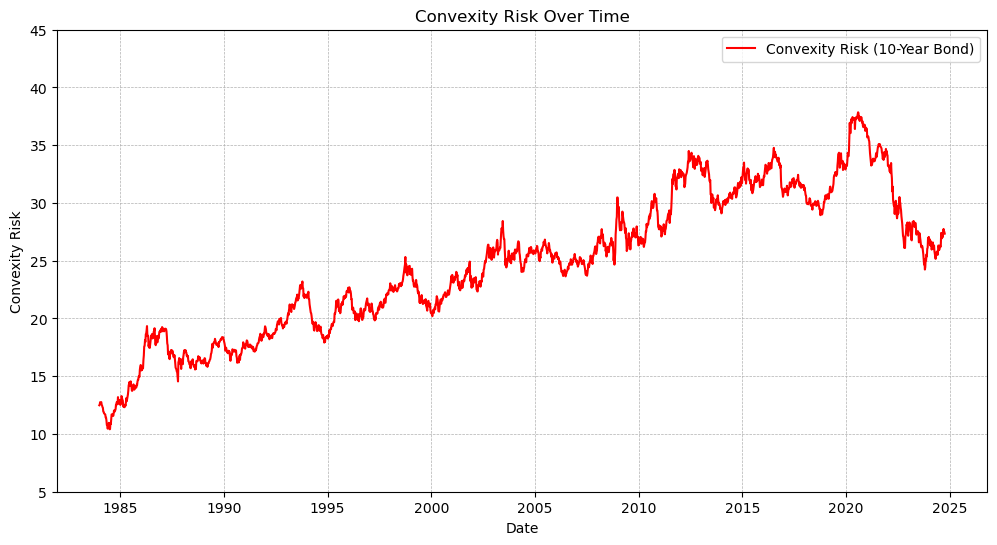

In [42]:
# Plot the convexity risk over time
plt.figure(figsize=(12, 6))
plt.plot(total_return_10pct.index, total_return_10pct['convexity_risk_10'], color="red", label="Convexity Risk (10-Year Bond)")
plt.title("Convexity Risk Over Time")
plt.ylim(5, 45)
plt.xlabel("Date")
plt.ylabel("Convexity Risk")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

In summary, for a flattener strategy using 2-year and 10-year zero-coupon bonds, the increasing convexity risk over time could signal higher sensitivity to yield curve changes, affecting strategy outcomes. Peaks in convexity risk may represent riskier periods, while troughs suggest potentially lower risk but possibly reduced strategy effectiveness.

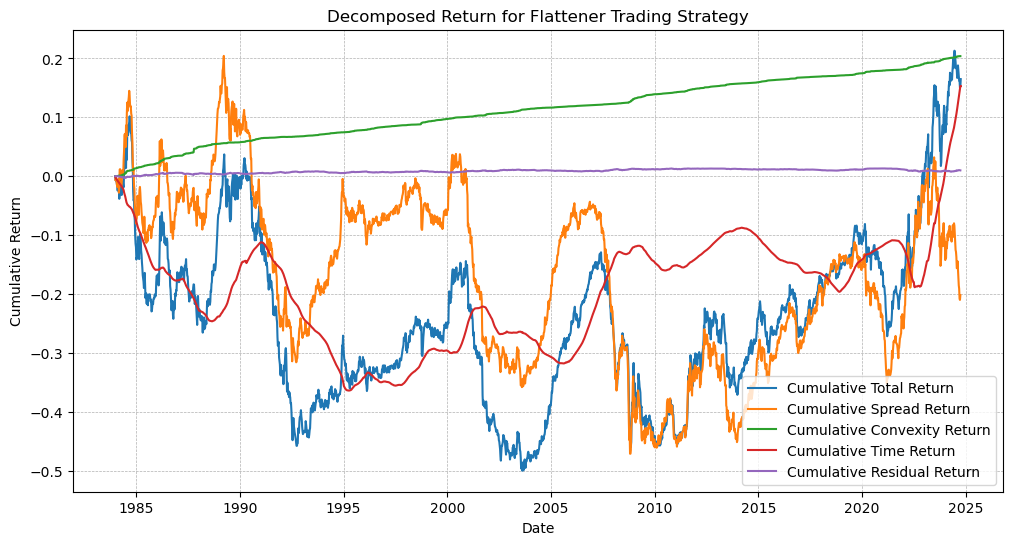

In [15]:
# Decompose returns into spread return, convexity return, time return, and residual return

# Spread return calculation
total_return_10pct['yield_diff.10yr'] = total_return_10pct['yield.10yr.on'].shift(-1) - total_return_10pct['yield.10yr.on']
total_return_10pct['yield_diff.2yr'] = total_return_10pct['yield.2yr.on'].shift(-1) - total_return_10pct['yield.2yr.on']
total_return_10pct['delta_10'] = -total_return_10pct['DV01.10yr'] * total_return_10pct['yield_diff.10yr']
total_return_10pct['delta_2'] = total_return_10pct['DV01.2yr'] * total_return_10pct['yield_diff.2yr']
total_return_10pct['spread_return'] = (total_return_10pct['delta_10'] + total_return_10pct['X'] * total_return_10pct['delta_2']) * 100 * total_return_10pct['position']#need to adjust for 100 facevalue
total_return_10pct['cum_spread_return'] = (1_000_000 + total_return_10pct['spread_return'].cumsum()) / 1_000_000 - 1

# Convexity return calculation
total_return_10pct['convexity_10'] = 0.5 * 10 ** 2 * total_return_10pct['price.10yr.on'] * (total_return_10pct['yield_diff.10yr'] / 100) ** 2
total_return_10pct['convexity_2'] = 0.5 * 2 ** 2 * total_return_10pct['price.2yr.on'] * (total_return_10pct['yield_diff.2yr'] / 100) ** 2
total_return_10pct['convexity_return'] = total_return_10pct['position'] * (total_return_10pct['convexity_10'] - total_return_10pct['convexity_2'] * total_return_10pct['X'])
total_return_10pct['cum_convexity_return'] = (1_000_000 + total_return_10pct['convexity_return'].cumsum()) / 1_000_000 - 1

# Time return calculation
total_return_10pct['d_price_no_shift.10yr'] = portfolio['price.10yr.off'] - portfolio['price.10yr.on']
total_return_10pct['d_price_no_shift.2yr'] = portfolio['price.2yr.off'] - portfolio['price.2yr.on']
total_return_10pct['time_return'] = (
    (total_return_10pct['d_price_no_shift.10yr'] - total_return_10pct['d_price_no_shift.2yr'] * total_return_10pct['X']) *
    total_return_10pct['position'] + total_return_10pct['interest_on_cash']
)
total_return_10pct['cum_time_return'] = (1_000_000 + total_return_10pct['time_return'].cumsum()) / 1_000_000 - 1

# Residual return calculation
total_return_10pct['residual'] = (
    total_return_10pct['interest_on_cash'] +
    total_return_10pct['position_revenue'] -
    total_return_10pct['spread_return'] -
    total_return_10pct['convexity_return'] -
    total_return_10pct['time_return']
)
total_return_10pct['cum_residual'] = (1_000_000 + total_return_10pct['residual'].cumsum()) / 1_000_000 - 1

# Combining the cumulative returns for each return type
Returns = pd.DataFrame({
    "Cumulative Total Return": total_return_10pct['cumulative_return'],
    "Cumulative Spread Return": total_return_10pct['cum_spread_return'],
    "Cumulative Convexity Return": total_return_10pct['cum_convexity_return'],
    "Cumulative Time Return": total_return_10pct['cum_time_return'],
    "Cumulative Residual Return": total_return_10pct['cum_residual']
})

# Plotting the decomposed returns
plt.figure(figsize=(12, 6))
for column in Returns.columns:
    plt.plot(Returns.index, Returns[column], label=column)
plt.title("Decomposed Return for Flattener Trading Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(loc="best")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


The residual return line is relatively flat, with minor fluctuations, suggesting that the main components (spread, convexity, and time returns) capture most of the strategy's dynamics and minor variations could be due to transaction costs, model inaccuracies, or market noise.

**Summary:**  


* Primary Drivers of Total Return:  
    * Spread return (orange line) is the most volatile component and has the largest impact on total return fluctuations. The periods of steep decline in total return, such as in the early 1990s, early 2000s, and post-2020, are primarily due to significant declines in spread return, likely due to yield curve steepening during those times.  
    * Convexity return (green line) is a steady, positive contributor, providing a stabilizing effect. Its consistent upward trend helps offset declines in spread return, particularly in low-rate environments, where convexity effects are more pronounced.  
    * Time return (red line) provides a modest but consistent positive contribution to total return. While it’s less prominent than convexity, time return acts as a low-volatility buffer, helping to sustain positive returns over time.  
* Relationship between Spread, Convexity, and Time Returns:  
    * Spread return is highly sensitive to changes in the yield curve shape, driving most of the volatility in total return.  
    * Convexity return increases steadily due to the non-linear benefits of the long bond’s convexity, especially in low-yield environments. This component supports the strategy through periods of flattening yield curves or stable low rates.  
    * Time return is relatively stable, adding consistent gains due to bond roll-down and cash yield, even when spread return is negative.

C:\Users\76721\AppData\Local\Temp\ipykernel_9464\144451647.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  portfolio['capital'].iloc[0] = 1_000_000  # Start with an initial capital of $1,000,000


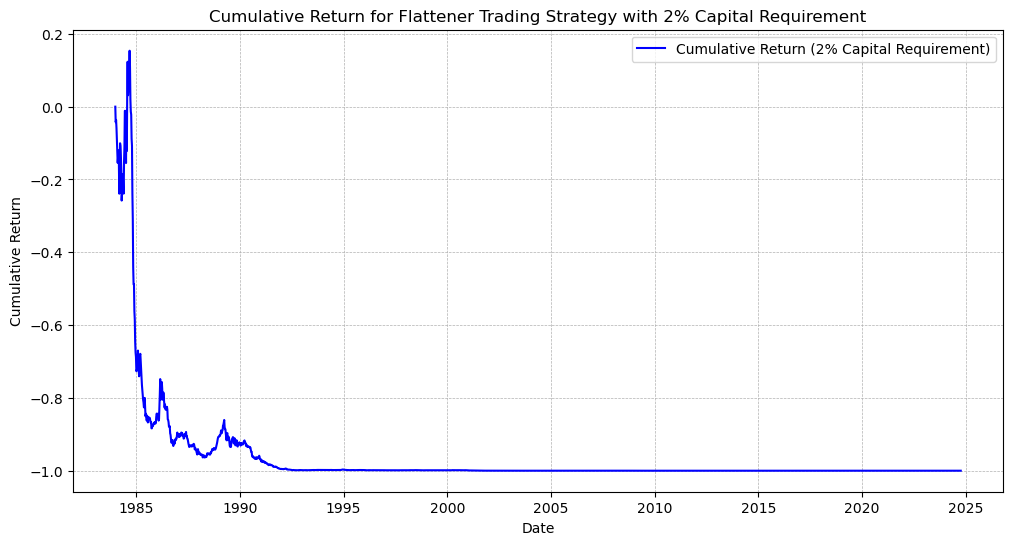

In [19]:
# Set leverage ratio for a 2% capital requirement
leverage_ratio_2pct = 1 / 0.02

# Run the flattener trade simulation for a 2% capital requirement
total_return_2pct = flattener_trade(portfolio, leverage_ratio_2pct)

# Plot the cumulative return over time for the 2% capital requirement
plt.figure(figsize=(12, 6))
plt.plot(total_return_2pct.index, total_return_2pct['cumulative_return'], label="Cumulative Return (2% Capital Requirement)", color="blue")
plt.title("Cumulative Return for Flattener Trading Strategy with 2% Capital Requirement")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()


The cumulative return graph for the flattener strategy with a 2% capital requirement demonstrates:

* High initial volatility and a sharp decline in cumulative return due to likely steepening yield curves in the early period.
* A sustained loss near -1.0 from 1990 onward, suggesting the strategy could not recover under the prevailing market conditions.
* The amplified risk from high leverage, which led to large early losses, illustrating the risks associated with a highly leveraged flattener strategy in environments that do not consistently support a flattening yield curve.